# Assignement 1: Ford-Fulkerson Implementation and Analysis
## Objectives
1. Implement the Ford-Fulkerson method.
2. Conduct empirical experiments with networks of various sizes.
3. Analyze and compare execution times with theoretical complexity.
4. Create figures to illustrate your results.

## Method Implementation
This section is focused on implementing Ford-Fulkerson Method using Breath-First Search.

In [6]:
# Edge representation
mutable struct Edge
    u::Int
    v::Int
    flow::Int
    capacity::Int
end

# Graph representation
mutable struct MyGraph
    adj::Dict{Int, Vector{Edge}}
end

# Function for adding edge to the graph
function add_edge!(graph::MyGraph, u::Int, v::Int, capacity::Int)
    if !haskey(graph.adj, u)
        graph.adj[u] = Vector{Edge}()
    end
    
    if !haskey(graph.adj, v)
        graph.adj[v] = Vector{Edge}()
    end

    push!(graph.adj[u], Edge(u, v, 0, capacity))
    push!(graph.adj[v], Edge(v, u, 0, 0))
end

# BFS path-seeking algorithm
function bfs(graph::MyGraph, source::Int, sink::Int)
    visited = Dict{Int, Bool}()
    pi = Dict{Int, Edge}()
    queue = [source]
    visited[source] = true
    min_capacity = Dict{Int, Int}()
    min_capacity[source] = typemax(Int)
    
    while !isempty(queue)
        u::Int = popfirst!(queue)
        
        for edge::Edge in graph.adj[u]
            v::Int = edge.v
            res_capacity::Int = edge.capacity - edge.flow
            
            if !get(visited, v, false) && res_capacity > 0
                visited[v] = true
                pi[v] = edge
                min_capacity[v] = min(min_capacity[u], res_capacity)
                
                if v == sink
                    return true, pi, min_capacity[sink]
                end
                
                push!(queue, v)
            end
        end
    end
    
    return false, Dict{Int, Edge}(), 0
end



# Updating graph based on found path
function update_graph!(graph::MyGraph, pi::Dict{Int, Edge}, flow::Int)
    v = maximum(keys(pi))
    
    while haskey(pi, v)
        edge = pi[v]
        
        # Update forward edge flow
        for e in graph.adj[edge.u]
            if e.u == edge.u && e.v == edge.v
                e.flow += flow
                break
            end
        end
        
        # Update backward edge flow
        for e in graph.adj[edge.v]
            if e.u == edge.v && e.v == edge.u
                e.flow -= flow
                break
            end
        end
        
        v = edge.u
    end
end

update_graph! (generic function with 1 method)

In [7]:
# Ford-fulkerson method using bfs
function ford_fulkerson(graph::MyGraph, source::Int, sink::Int)
    max_flow = 0
    
    while true
        found, path, flow = bfs(graph, source, sink)
        
        if !found
            break
        end

        update_graph!(graph, path, flow)
        max_flow += flow
    end
    
    return max_flow
end

ford_fulkerson (generic function with 1 method)

In [8]:
# Simple test if the method is working fine on known example
graph = MyGraph(Dict{Int, Vector{Edge}}())

# Example from Introduction to Algorithms page 678
# Expected result: max_flow = 23
add_edge!(graph, 0, 1, 16)
add_edge!(graph, 0, 2, 13)
add_edge!(graph, 2, 1, 4)
add_edge!(graph, 1, 3, 12)
add_edge!(graph, 3, 2, 9)
add_edge!(graph, 2, 4, 14)
add_edge!(graph, 4, 3, 7)
add_edge!(graph, 4, 5, 4)
add_edge!(graph, 3, 5, 20)

max_flow = ford_fulkerson(graph, 0, 5)
println("Max Flow: ", max_flow)

Max Flow: 23


## Experiments setup

In [10]:
function generate_connected_graph(n::Int, m::Int, source::Int, sink::Int) # where n are nodes and m are edges
    graph = MyGraph(Dict{Int, Vector{Edge}}())

    # Line from source to sink
    for i in 1:n-1
        add_edge!(graph, i, i+1, rand(1:15))
    end

    # Add random edges to the graph
    for _ in 1:m - (n - 1)
        u, v = rand(1:n), rand(1:n)
        capacity = rand(1:10)
        
        # Avoid self-loops
        if u != v && !any(e -> e.u == u && e.v == v, graph.adj[u])
            add_edge!(graph, u, v, capacity)
        end
    end

    return graph
end

generate_connected_graph (generic function with 1 method)

Size: 1000 | Average time: 0.00031585 sec | Total time: 0.0031585 sec | Times: [0.0007931, 0.0002645, 0.0002663, 0.0002752, 0.0002638, 0.0002561, 0.0002524, 0.0002562, 0.0002728, 0.0002581]
Size: 5000 | Average time: 0.003987350000000001 sec | Total time: 0.039873500000000006 sec | Times: [0.0207137, 0.002231, 0.0020675, 0.0020402, 0.0019762, 0.0025051, 0.0021475, 0.0021553, 0.0020615, 0.0019755]
Size: 7500 | Average time: 0.013980679999999995 sec | Total time: 0.13980679999999995 sec | 
 Times: [0.1000277, 0.0030798, 0.0037468, 0.0039211, 0.0046613, 0.0046293, 0.0046973, 0.0047317, 0.0049629, 0.0053489]
Size: 11250 | Average time: 0.01749231 sec | Total time: 0.1749231 sec | 
 Times: [0.1749187, 6.0e-7, 5.0e-7, 7.0e-7, 5.0e-7, 4.0e-7, 4.0e-7, 4.0e-7, 4.0e-7, 5.0e-7]
Size: 16875 | Average time: 0.06359106 sec | Total time: 0.6359106000000001 sec | 
 Times: [0.449644, 0.0209257, 0.0177489, 0.0170724, 0.0177209, 0.0173556, 0.0236976, 0.0309886, 0.0202825, 0.0204744]
Size: 25312 | Average

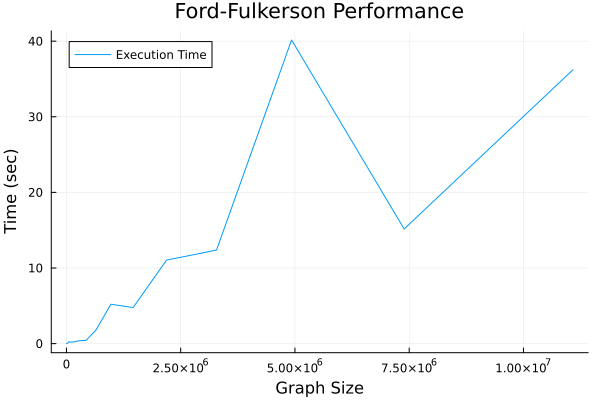

In [20]:
using BenchmarkTools
using Statistics
using Plots

function measure_time(graph::MyGraph, source::Int, sink::Int; instances::Int=10)
    instance_times = [@elapsed ford_fulkerson(graph, source, sink) for _ in 1:instances]
    total_time = sum(instance_times)
    avg_time = mean(instance_times)
    return avg_time, total_time, instance_times
end

function find_graph_sizes()
    base_sizes = [1000, 5000]  # Initial safe sizes
    source = 1
    max_total_time = 420  # 7 minutes
    times = Float64[]
    sizes = Int[]

    # Dynamically test larger sizes
    next_size = 0
    last_size = base_sizes[end]
    while next_size < 15000000
        next_size = Int(round(last_size * 1.5))  # Increase size progressively
        sink = next_size
        graph = generate_connected_graph(next_size, 3*next_size, source, sink)
        avg_time, total_time, instance_times = measure_time(graph, source, sink)

        if total_time > max_total_time
            println("Computation of 10 instances for graph $next_size exceeded 7 minutes")
            break
        end

        push!(times, avg_time)
        push!(sizes, next_size)
        last_size = next_size
        println("Size: $next_size | Average time: $avg_time sec | Total time: $total_time sec | \nTimes: $instance_times\n")
    end

    return sizes, times
end

# Run experiment and plot
sizes, times = find_graph_sizes()
plot(sizes, times, label="Execution Time", xlabel="Graph Size", ylabel="Time (sec)", title="Ford-Fulkerson Performance")
plot!(xscale=:log10, minorgrid=true)